In [3]:
from collections import Counter
from datetime import datetime, timedelta as td
import math
from matplotlib import gridspec, pyplot as plt, rc, ticker
import numpy as np
import pandas as pd
import os
from scipy.stats import poisson
import sys

dtf = datetime.strftime
dtp = datetime.strptime

plt.style.use(['science','ieee'])

In [4]:
class ExpLogHandler:
    """Class to find, combine, and pre-process all required data files.

    Args:
        log_names (list): List of names of required log files.

    Attributes:
        log_names (list): Where log_names is stored.
    """
    def __init__(self, log_names):
        """Initialiser for the ExpLogHandler class.

        Args:
            log_names (list): List of names of required log files.
        """
        self.log_names = log_names
        
    def getData(self):
        """Acquire data files, combine, remove duplicate column headers, join indices

        Args:
            None
        
        Returns:
            data: Complete DataFrame of all experiment log lines.
        """

        self.data = pd.read_csv(self.log_names[0], on_bad_lines="skip", dtype={'SDC_val': str})
        for i in range(1, len(self.log_names)):
            data_next   = pd.read_csv(self.log_names[i], on_bad_lines="skip", dtype={'SDC_val': str})
            data_frames = [self.data, data_next]
            self.data   = pd.concat(data_frames, ignore_index=True)
        self.data.drop(self.data.loc[(self.data["Timestamp"] == "Timestamp")].index.tolist())
        self.dataLength = self.data.shape[0]

        wrchckbrdLocs  = self.data.loc[(self.data["Board"] == "M") & (self.data["Mikroe_socket"] == "A") &
                                       (self.data["Status"] == "WRCHCKBRD")].index.tolist()
        wrchckbrdIndex = [(i, "WRCHCKBRD") for i in wrchckbrdLocs]
        initLocs       = self.data.loc[(self.data["Board"] == "M") & (self.data["Mikroe_socket"] == "A") &
                         (self.data["Status"] == "INIT")].index.tolist()
        initIndex      = [(i, "INIT") for i in initLocs]
        runIndex       = wrchckbrdIndex + initIndex
        runIndex       = sorted(runIndex)
        runIndex.append((self.dataLength, "END"))

        runId  = 1
        runCol = [''] * self.dataLength
        for h in range(len(runIndex) - 1):
            if runIndex[h][1] == "WRCHCKBRD":
                start              = runIndex[h][0]
                end                = runIndex[h+1][0]
                runCol[start:end]  = [runId]*(end-start)
                runId              += 1

        self.data.insert(loc=0, column="Run_ID", value=runCol)
        return self.data

In [5]:
class BeamLogHandler:
    """Class to retrieve all neutron logs for experiment dates.

    Attributes:
        beamLogFnameFormat (str): Datetime format for beamlog file names.
        firstTime (datetime): Datetime object of first experiment timestamp.
        lastTime (datetime): Datetime object of last experiment timestamp.
        targetDir_fullpathList (list): List of each parent directory of experiment results directory.
    
    """
    def __init__(self, firstTime, lastTime, targetDir_fullpathList):     
        self.beamLogFnameFormat          = "%Y-%m-%d"
        self.firstTime                   = firstTime
        self.lastTime                    = lastTime
        self.targetDir_fullpathList      = targetDir_fullpathList
        self.targetDir_fullpathList[-4:] = ["neutrons"]

    def getLogs(self):
        firstBeamTime = dtf(self.firstTime, self.beamLogFnameFormat)
        beamlogDayDif = (self.lastTime - self.firstTime).days
        beamPath      = "../../../neutrons/countlog-"
        self.beamlog  = pd.read_csv(f"{beamPath}{firstBeamTime}.txt",
                        delim_whitespace=True, header=None, skiprows=1)
        nextTime      = self.firstTime
        for i in range(0, beamlogDayDif+1):
            nextTime      = nextTime + td(days=1)
            nextBeamTime  = dtf(nextTime, self.beamLogFnameFormat)
            try:
                nextBeamlog   = pd.read_csv(f"{beamPath}{nextBeamTime}.txt",delim_whitespace=True,header=None,skiprows=1)
            except FileNotFoundError:
                pass
            beamlogFrames = [self.beamlog, nextBeamlog]
            self.beamlog  = pd.concat(beamlogFrames, ignore_index=True)
            
        self.beamlog.columns = ["Date","HMS_time","Millisecs","Count1","Count2",
                                "Count3","Count4","protonCharge","Beam_current"]
        return self.beamlog

In [6]:
class Run:
    """Class for one repetition of an experiment.

    Args:
        num (int): Run number for the selected experiment logs.
        runData (DataFrame): Truncated DataFrame of log lines for the run.
    
    Attributes:
        delay (int): Length in milliseconds of beam 'bathing time'.
        df (DataFrame): Saving runData.
        errors (int): Number of nvRAM errors.
        fullErr (int): 1 if the entire nvRAM array was errored.
        hot (int): 1 if the beam was on, 0 if not.
        num (int): Saving num.
        rowErr (int): 1 if there was at least one row error.
        see (int): Number of true SEEs detected.
        valid (int): 1 if the run had all expected log lines, 0 if not.
        _ErrorsNVRAM (list): List of tuples (error_byte, error_location) for each chip.
    """
    def __init__(self, num, runData):
        """Initialiser for the Run class. 

        Parameters:
            num (int): Run number for the selected experiment logs.
            runData (DataFrame): Truncated DataFrame of log lines for the run.
        """
        self.delay     = -1
        self.df        = runData
        self.errors    = 0
        self.fullErr   = -1
        self.hot       = -1
        self.num       = num
        self.rowErr    = -1
        self.see       = -1
        self.valid     = -1
        self.aErrNVRAM = []
        self.bErrNVRAM = []
        self.cErrNVRAM = []
        self.dErrNVRAM = []
        self.aErrorBounds = []
        self.bErrorBounds = []
        self.cErrorBounds = []
        self.dErrorBounds = []
        self.aErrNVRAMVals = []
        self.bErrNVRAMVals = []
        self.cErrNVRAMVals = []
        self.dErrNVRAMVals = []
        self.aErrNVRAMLocs = []
        self.bErrNVRAMLocs = []
        self.cErrNVRAMLocs = []
        self.dErrNVRAMLocs = []

In [7]:
class Analyser:
    '''
    Class to handle processing data.

    Args:
        targetDir_fullpath (string): File path of directory to analyse.

    Attributes:
        targetDir_fullpath (string): Storing targetDir_fullpath arg.
        expLogTstampFormat (string): Datetime format for experiment log timestamps
        beamLogTstampFormat (string): Datetime format for beam log timestamps                
    '''
    def __init__(self, targDir_full):
        '''
        Retrieve + store target directory, initialise datetime formats.

        Args:
            targetDir_fullpath (string): File path of directory to analyse.

        Attributes:
            ignores (string): Experiment run IDs to ignore during processing
            targetDir_fullpath (string): Storing targetDir_fullpath arg.
            expLogTstampFormat (string): Datetime format for experiment log timestamps
            beamLogTstampFormat (string): Datetime format for beam log timestamps
        '''
        self.ignores = []
        self.targDir_full = targDir_full
        self.expLogTstampFormat  = "%Y-%m-%d_%H-%M-%S-%f"
        self.beamLogTstampFormat = "%d/%m/%Y %H:%M:%S"
 
    def setup(self):
        #targetDir_fullpathList = self.targDir_full.split("/")
        targDir_fullList = self.targDir_full.split("/")
        targDir_trunc    = targDir_fullList[-4:-1]
        self.chip        = targDir_trunc[0]
        self.variant     = targDir_trunc[1]
        self.size        = targDir_trunc[2]

        # Get data from logs
        self.log_names     = [self.targDir_full+i for i in os.listdir(self.targDir_full) if ".csv" in i]
        self.log_names.sort(key = lambda x: dtp(x, f"{self.targDir_full}nvRAM_data_%d-%m-%Y-%H%M.csv"))
        self.ExpLogHandler = ExpLogHandler(self.log_names)
        self.data          = self.ExpLogHandler.getData()

        # Get MikroE socket for single-size experiments
        if self.size == 'single':
            self.single_socket = sram3_1_single.data.iloc[1]['Mikroe_socket']

        # Get beam status from logs
        firstTimestamp      = self.data[0:1]['Timestamp'][0]
        lastTimestamp       = self.data[self.data.shape[0]-2:self.data.shape[0]-1]['Timestamp'][self.data.shape[0]-2]
        firstTime           = dtp(firstTimestamp, self.expLogTstampFormat)
        lastTime            = dtp(lastTimestamp, self.expLogTstampFormat)
        self.BeamLogHandler = BeamLogHandler(firstTime, lastTime, targDir_fullList)
        self.beamlog        = self.BeamLogHandler.getLogs()

        # Create datetime objects from beamlog timestamps
        beamlogTstamps    = (self.beamlog['Date']+self.beamlog['HMS_time']+self.beamlog['Millisecs'].apply(str)).tolist()
        self.beamlogTimes = []
        for i in beamlogTstamps:
            if len(i) > 23:
                i = i[0:26]
            self.beamlogTimes.append(i)
        self.beamlogTimes = [dtp(i, '%d/%m/%Y%H:%M:%S0.%f') for i in self.beamlogTimes]

    def beamOn(self, firstTstamp, lastTstamp):
        bOfirstTime = firstTstamp
        bOlastTime = lastTstamp
        beamTimeNearFirstTime = min([i for i in self.beamlogTimes if i <= bOfirstTime], key=lambda x: abs(x - bOfirstTime))
        beamTimeNearLastTime  = min([i for i in self.beamlogTimes if i >= bOlastTime], key=lambda x: abs(x - bOlastTime))
        firstRow              = self.beamlog.loc[(self.beamlog['Date'] == dtf(beamTimeNearFirstTime, '%d/%m/%Y')) &
                                (self.beamlog['HMS_time'] == dtf(beamTimeNearFirstTime, '%H:%M:%S'))]
        lastRow               = self.beamlog.loc[(self.beamlog['Date'] == dtf(beamTimeNearLastTime, '%d/%m/%Y')) & 
                                (self.beamlog['HMS_time'] == dtf(beamTimeNearLastTime, '%H:%M:%S'))]
        count4Dif             = lastRow.iloc[0]['Count4'] - firstRow.iloc[0]['Count4']
        numRows               = lastRow.index.astype(int)[0] - firstRow.index.astype(int)[0]
        cps                   = count4Dif / numRows
        if cps > 1:
            return 1
        return 0

    def createRuns(self):
        runNames  = []
        self.runs = {}
        lastRunID =  self.data[self.data['Run_ID'].last_valid_index():self.data['Run_ID'].
                     last_valid_index()+1]['Run_ID'][self.data['Run_ID'].last_valid_index()]

        # Supply Run initialiser with truncated data 
        for i in range(1, lastRunID + 1):
            runNames.append(f"run_{i}")
            runData      = self.data.loc[(self.data["Run_ID"] == i)]
            runData.reset_index(inplace=True, drop=True)
            self.runs[i] = Run(i, runData)

        # TODO: Add logic for single-chip runs, currently only supporting half experiment runs.

        for run in self.runs.values():
            if self.variant == "1":
                    try:
                        # Extract beam delay from timestamps
                        if self.size == 'single':
                            before_delay_i  = run.df.loc[(run.df['Mikroe_socket']==self.single_socket) & (run.df['Status']=='STORE_OK')].index[0]
                            before_delay_t  = run.df.loc[before_delay_i]['Timestamp']
                            after_delay_i   = run.df.loc[(run.df['Mikroe_socket']==self.single_socket) & (run.df['Status']=='VERIF')].index[0] + 1
                            after_delay_t   = run.df.loc[after_delay_i]['Timestamp']
                        else:
                            before_delay_i  = run.df.loc[(run.df['Mikroe_socket']=='D') & (run.df['Status']=='STORE_OK')].index[0]
                            before_delay_t  = run.df.loc[before_delay_i]['Timestamp']
                            after_delay_i   = run.df.loc[(run.df['Mikroe_socket']=='A') & (run.df['Status']=='VERIF')].index[0] + 1
                            after_delay_t   = run.df.loc[after_delay_i]['Timestamp']
                        before_delay_dt = dtp(before_delay_t, self.expLogTstampFormat)
                        after_delay_dt  = dtp(after_delay_t, self.expLogTstampFormat)   
                        dif             = after_delay_dt - before_delay_dt
                        
                        if dif < td(seconds = 0.5):
                            run.delay = 0.1
                        if td(seconds = 0.5) < dif < td(seconds = 5):
                            run.delay = 1
                        if td(seconds = 5)   < dif < td(seconds = 50):
                            run.delay = 10
                        if td(seconds = 50)  < dif < td(seconds = 500):
                            run.delay = 100
                        if td(seconds = 500) < dif < td(seconds = 5000):
                            run.delay = 1000

                        # Was the beam on?
                        try:
                            if self.beamOn(before_delay_dt, after_delay_dt):
                                run.hot = 1
                            else:
                                run.hot = 0
                        except ValueError:
                            print(run.name)

                        # Create list of errors in nvRAM per chip
                        aErrorBounds = list(zip(run.df.loc[(run.df["Mikroe_socket"] == "A") & 
                                            (run.df["Status"] == "VERIF")].index.tolist(),
                                                run.df.loc[(run.df["Mikroe_socket"] == "A") & 
                                            (run.df["Status"] == "VERIF_OK")].index.tolist()))

                        bErrorBounds = list(zip(run.df.loc[(run.df["Mikroe_socket"] == "B") & 
                                            (run.df["Status"] == "VERIF")].index.tolist(),
                                                run.df.loc[(run.df["Mikroe_socket"] == "B") &
                                            (run.df["Status"] == "VERIF_OK")].index.tolist()))

                        cErrorBounds = list(zip(run.df.loc[(run.df["Mikroe_socket"] == "C") & 
                                            (run.df["Status"] == "VERIF")].index.tolist(),
                                                run.df.loc[(run.df["Mikroe_socket"] == "C") & 
                                            (run.df["Status"] == "VERIF_OK")].index.tolist()))

                        dErrorBounds = list(zip(run.df.loc[(run.df["Mikroe_socket"] == "D") & 
                                            (run.df["Status"] == "VERIF")].index.tolist(),
                                                run.df.loc[(run.df["Mikroe_socket"] == "D") & 
                                            (run.df["Status"] == "VERIF_OK")].index.tolist()))

                        aErrorsBefRec = list(zip(run.df[aErrorBounds[0][0]+1:aErrorBounds[0][1]]["SDC_val"].values.tolist(),
                                                run.df[aErrorBounds[0][0]+1:aErrorBounds[0][1]]["SDC_loc"].values.tolist()))
                        aErrorsAftRec = list(zip(run.df[aErrorBounds[1][0]+1:aErrorBounds[1][1]]["SDC_val"].values.tolist(),
                                                run.df[aErrorBounds[1][0]+1:aErrorBounds[1][1]]["SDC_loc"].values.tolist()))

                        bErrorsBefRec = list(zip(run.df[bErrorBounds[0][0]+1:bErrorBounds[0][1]]["SDC_val"].values.tolist(),
                                                run.df[bErrorBounds[0][0]+1:bErrorBounds[0][1]]["SDC_loc"].values.tolist()))
                        bErrorsAftRec = list(zip(run.df[bErrorBounds[1][0]+1:bErrorBounds[1][1]]["SDC_val"].values.tolist(),
                                                run.df[bErrorBounds[1][0]+1:bErrorBounds[1][1]]["SDC_loc"].values.tolist()))

                        cErrorsBefRec = list(zip(run.df[cErrorBounds[0][0]+1:cErrorBounds[0][1]]["SDC_val"].values.tolist(),
                                                run.df[cErrorBounds[0][0]+1:cErrorBounds[0][1]]["SDC_loc"].values.tolist()))
                        cErrorsAftRec = list(zip(run.df[cErrorBounds[1][0]+1:cErrorBounds[1][1]]["SDC_val"].values.tolist(),
                                                run.df[cErrorBounds[1][0]+1:cErrorBounds[1][1]]["SDC_loc"].values.tolist()))

                        dErrorsBefRec = list(zip(run.df[dErrorBounds[0][0]+1:dErrorBounds[0][1]]["SDC_val"].values.tolist(),
                                                run.df[dErrorBounds[0][0]+1:dErrorBounds[0][1]]["SDC_loc"].values.tolist()))
                        dErrorsAftRec = list(zip(run.df[dErrorBounds[1][0]+1:dErrorBounds[1][1]]["SDC_val"].values.tolist(),
                                                run.df[dErrorBounds[1][0]+1:dErrorBounds[1][1]]["SDC_loc"].values.tolist())) 
                        
                        run.aErrNVRAM = [i for i in bErrorsAftRec if i not in bErrorsBefRec if np.nan not in i]
                        run.bErrNVRAM = [i for i in bErrorsAftRec if i not in bErrorsBefRec if np.nan not in i]
                        run.cErrNVRAM = [i for i in cErrorsAftRec if i not in cErrorsBefRec if np.nan not in i]
                        run.dErrNVRAM = [i for i in dErrorsAftRec if i not in dErrorsBefRec if np.nan not in i]

                        run.errors += len(run.aErrNVRAM)
                        run.errors += len(run.bErrNVRAM)
                        run.errors += len(run.cErrNVRAM)
                        run.errors += len(run.dErrNVRAM)

                    except IndexError:
                        run.valid = 0
                    else:
                        run.valid = 1
                        
            if self.variant == "2":
                try:
                # Extract beam delay from timestamps
                    if self.size == 'single':
                        before_delay_i  = run.df.loc[(run.df['Mikroe_socket']==self.single_socket) & (run.df['Status']=='STORE_OK')].index[0]
                        before_delay_t  = run.df.loc[before_delay_i]['Timestamp']
                        after_delay_i   = run.df.loc[(run.df['Mikroe_socket']==self.single_socket) & (run.df['Status']=='VERIF')].index[0] + 1
                        after_delay_t   = run.df.loc[after_delay_i]['Timestamp']
                    else:
                        before_delay_i  = run.df.loc[(run.df['Mikroe_socket']=='D') & (run.df['Status']=='STORE_OK')].index[0]
                        before_delay_t  = run.df.loc[before_delay_i]['Timestamp']
                        after_delay_i   = run.df.loc[(run.df['Mikroe_socket']=='A') & (run.df['Status']=='VERIF')].index[0] + 1
                        after_delay_t   = run.df.loc[after_delay_i]['Timestamp']
                    before_delay_dt = dtp(before_delay_t, self.expLogTstampFormat)
                    after_delay_dt  = dtp(after_delay_t, self.expLogTstampFormat)   
                    dif             = after_delay_dt - before_delay_dt
                    
                    if td(seconds = 0.1) < dif < td(seconds = 0.5):
                        run.delay = 0.1
                    if td(seconds = 0.5) < dif < td(seconds = 5):
                        run.delay = 1
                    if td(seconds = 5)   < dif < td(seconds = 50):
                        run.delay = 10
                    if td(seconds = 50)  < dif < td(seconds = 500):
                        run.delay = 100
                    if td(seconds = 500) < dif < td(seconds = 5000):
                        run.delay = 1000

                    # Was the beam on?
                    try:
                        if self.beamOn(before_delay_dt, after_delay_dt):
                            run.hot = 1
                        else:
                            run.hot = 0
                    except ValueError:
                        print(run.name)
                        
                    # Create list of errors in nvRAM per chip
                    aErrorBounds = list(zip(run.df.loc[(run.df["Mikroe_socket"] == "A") & 
                                        (run.df["Status"] == "VERIF")].index.tolist(),
                                            run.df.loc[(run.df["Mikroe_socket"] == "A") & 
                                        (run.df["Status"] == "VERIF_OK")].index.tolist()))

                    bErrorBounds = list(zip(run.df.loc[(run.df["Mikroe_socket"] == "B") & 
                                        (run.df["Status"] == "VERIF")].index.tolist(),
                                            run.df.loc[(run.df["Mikroe_socket"] == "B") &
                                        (run.df["Status"] == "VERIF_OK")].index.tolist()))

                    cErrorBounds = list(zip(run.df.loc[(run.df["Mikroe_socket"] == "C") & 
                                        (run.df["Status"] == "VERIF")].index.tolist(),
                                            run.df.loc[(run.df["Mikroe_socket"] == "C") & 
                                        (run.df["Status"] == "VERIF_OK")].index.tolist()))

                    dErrorBounds = list(zip(run.df.loc[(run.df["Mikroe_socket"] == "D") & 
                                        (run.df["Status"] == "VERIF")].index.tolist(),
                                            run.df.loc[(run.df["Mikroe_socket"] == "D") & 
                                        (run.df["Status"] == "VERIF_OK")].index.tolist()))

                    aErrBefDelay = list(zip(run.df[aErrorBounds[0][0]+1:aErrorBounds[0][1]]["SDC_val"].values.tolist(),
                                            run.df[aErrorBounds[0][0]+1:aErrorBounds[0][1]]["SDC_loc"].values.tolist()))
                    aErrBefRec = list(zip(run.df[aErrorBounds[1][0]+1:aErrorBounds[1][1]]["SDC_val"].values.tolist(),
                                            run.df[aErrorBounds[1][0]+1:aErrorBounds[1][1]]["SDC_loc"].values.tolist()))
                    aErrAftRec = list(zip(run.df[aErrorBounds[2][0]+1:aErrorBounds[2][1]]["SDC_val"].values.tolist(),
                                            run.df[aErrorBounds[2][0]+1:aErrorBounds[2][1]]["SDC_loc"].values.tolist()))

                    bErrBefDelay = list(zip(run.df[bErrorBounds[0][0]+1:bErrorBounds[0][1]]["SDC_val"].values.tolist(),
                                            run.df[bErrorBounds[0][0]+1:bErrorBounds[0][1]]["SDC_loc"].values.tolist()))
                    bErrBefRec = list(zip(run.df[bErrorBounds[1][0]+1:bErrorBounds[1][1]]["SDC_val"].values.tolist(),
                                            run.df[bErrorBounds[1][0]+1:bErrorBounds[1][1]]["SDC_loc"].values.tolist()))
                    bErrAftRec = list(zip(run.df[bErrorBounds[2][0]+1:bErrorBounds[2][1]]["SDC_val"].values.tolist(),
                                            run.df[bErrorBounds[2][0]+1:bErrorBounds[2][1]]["SDC_loc"].values.tolist()))
                    
                    cErrBefDelay = list(zip(run.df[cErrorBounds[0][0]+1:cErrorBounds[0][1]]["SDC_val"].values.tolist(),
                                            run.df[cErrorBounds[0][0]+1:cErrorBounds[0][1]]["SDC_loc"].values.tolist()))
                    cErrBefRec = list(zip(run.df[cErrorBounds[1][0]+1:cErrorBounds[1][1]]["SDC_val"].values.tolist(),
                                            run.df[cErrorBounds[1][0]+1:cErrorBounds[1][1]]["SDC_loc"].values.tolist()))
                    cErrAftRec = list(zip(run.df[cErrorBounds[2][0]+1:cErrorBounds[2][1]]["SDC_val"].values.tolist(),
                                            run.df[cErrorBounds[2][0]+1:cErrorBounds[2][1]]["SDC_loc"].values.tolist()))
                    
                    dErrBefDelay = list(zip(run.df[dErrorBounds[0][0]+1:dErrorBounds[0][1]]["SDC_val"].values.tolist(),
                                            run.df[dErrorBounds[0][0]+1:dErrorBounds[0][1]]["SDC_loc"].values.tolist()))
                    dErrBefRec = list(zip(run.df[dErrorBounds[1][0]+1:dErrorBounds[1][1]]["SDC_val"].values.tolist(),
                                            run.df[dErrorBounds[1][0]+1:dErrorBounds[1][1]]["SDC_loc"].values.tolist()))
                    dErrAftRec = list(zip(run.df[dErrorBounds[2][0]+1:dErrorBounds[2][1]]["SDC_val"].values.tolist(),
                                            run.df[dErrorBounds[2][0]+1:dErrorBounds[2][1]]["SDC_loc"].values.tolist()))
                    
                    run.aErrNVRAM = [i for i in aErrAftRec if i not in aErrBefDelay if i not in aErrBefRec if np.nan not in i]
                    run.bErrNVRAM = [i for i in bErrAftRec if i not in bErrBefDelay if i not in bErrBefRec if np.nan not in i]
                    run.cErrNVRAM = [i for i in cErrAftRec if i not in cErrBefDelay if i not in cErrBefRec if np.nan not in i]
                    run.dErrNVRAM = [i for i in dErrAftRec if i not in dErrBefDelay if i not in dErrBefRec if np.nan not in i]
                    
                    run.errors += len(run.aErrNVRAM)
                    run.errors += len(run.bErrNVRAM)
                    run.errors += len(run.cErrNVRAM)
                    run.errors += len(run.dErrNVRAM)

                # Invalidate run if critical experiment steps didn't occur
                except IndexError:
                    run.valid = 0
                else:
                    run.valid = 1


    def diffFinder(self, variant):
        '''Find runs with large patterns in error location.
        '''
        patterns = []
        for run in variant.values():    
            diffA = [int(run.aErrNVRAM[i+1][1], 16) - int(run.aErrNVRAM[i][1], 16) 
                            for i in range(0, len(run.aErrNVRAM)-1)]
            diffB = [int(run.bErrNVRAM[i+1][1], 16) - int(run.bErrNVRAM[i][1], 16)
                            for i in range(0, len(run.bErrNVRAM)-1)]
            diffC = [int(run.cErrNVRAM[i+1][1], 16) - int(run.cErrNVRAM[i][1], 16)
                            for i in range(0, len(run.cErrNVRAM)-1)]
            diffD = [int(run.dErrNVRAM[i+1][1], 16) - int(run.dErrNVRAM[i][1], 16)
                            for i in range(0, len(run.dErrNVRAM)-1)]

            diffA2 = [abs(diffA[i+1] - diffA[i]) for i in range(0, len(diffA)-1)]
            diffB2 = [abs(diffB[i+1] - diffB[i]) for i in range(0, len(diffB)-1)]
            diffC2 = [abs(diffC[i+1] - diffC[i]) for i in range(0, len(diffC)-1)]
            diffD2 = [abs(diffD[i+1] - diffD[i]) for i in range(0, len(diffD)-1)]

            diffADict1 = {k: v for k, v in sorted(Counter(diffA).items(), reverse=True, key=lambda i: i[1])}
            diffBDict1 = {k: v for k, v in sorted(Counter(diffB).items(), reverse=True, key=lambda i: i[1])}
            diffCDict1 = {k: v for k, v in sorted(Counter(diffC).items(), reverse=True, key=lambda i: i[1])}
            diffDDict1 = {k: v for k, v in sorted(Counter(diffD).items(), reverse=True, key=lambda i: i[1])}

            diffADict2 = {k: v for k, v in sorted(Counter(diffA2).items(), reverse=True, key=lambda i: i[1])}
            diffBDict2 = {k: v for k, v in sorted(Counter(diffB2).items(), reverse=True, key=lambda i: i[1])}
            diffCDict2 = {k: v for k, v in sorted(Counter(diffC2).items(), reverse=True, key=lambda i: i[1])}
            diffDDict2 = {k: v for k, v in sorted(Counter(diffD2).items(), reverse=True, key=lambda i: i[1])}

            lastMemDigitA = [i[1][-1] for i in run.aErrNVRAM]
            lastMemDigitB = [i[1][-1] for i in run.bErrNVRAM]
            lastMemDigitC = [i[1][-1] for i in run.cErrNVRAM]
            lastMemDigitD = [i[1][-1] for i in run.dErrNVRAM]

            lmdADict = {k: v for k, v in sorted(Counter(lastMemDigitA).items(), reverse=True, key=lambda i: i[1])}
            lmdBDict = {k: v for k, v in sorted(Counter(lastMemDigitB).items(), reverse=True, key=lambda i: i[1])}
            lmdCDict = {k: v for k, v in sorted(Counter(lastMemDigitC).items(), reverse=True, key=lambda i: i[1])}
            lmdDDict = {k: v for k, v in sorted(Counter(lastMemDigitD).items(), reverse=True, key=lambda i: i[1])}

            if diffADict2:
                tot_err = len(run.aErrNVRAM)
                if list(diffADict2.items())[:1][0][1] >= 5:
                    if (list(diffADict2.items())[:1][0][1] / tot_err) > 0.1:
                        patterns.append(run.num)

            if diffBDict2:
                tot_err = len(run.bErrNVRAM)
                if list(diffBDict2.items())[:1][0][1] >= 5:
                    if (list(diffBDict2.items())[:1][0][1] / tot_err) > 0.1:
                        patterns.append(run.num)
            
            if diffCDict2:
                tot_err = len(run.cErrNVRAM)
                if list(diffCDict2.items())[:1][0][1] >= 5:
                    if (list(diffCDict2.items())[:1][0][1] / tot_err) > 0.1:
                        patterns.append(run.num)

            if diffDDict2:
                tot_err = len(run.dErrNVRAM)
                if list(diffDDict2.items())[:1][0][1] >= 5:
                    if (list(diffDDict2.items())[:1][0][1] / tot_err) > 0.1:
                        patterns.append(run.num)
                        
            else:
                if lmdADict:
                    if list(lmdADict.items())[:1][0][1] >= 5:
                        tot_err = len(run.aErrNVRAM)
                        if (list(lmdADict.items())[:1][0][1] / tot_err) > 0.75:
                            patterns.append(run.num)

                if lmdBDict:
                    if list(lmdBDict.items())[:1][0][1] >= 5:
                        tot_err = len(run.bErrNVRAM)
                        if (list(lmdBDict.items())[:1][0][1] / tot_err) > 0.75:
                            patterns.append(run.num)

                if lmdCDict:
                    if list(lmdCDict.items())[:1][0][1] >= 5:
                        tot_err = len(run.cErrNVRAM)
                        if (list(lmdCDict.items())[:1][0][1] / tot_err) > 0.75:
                            patterns.append(run.num)

                if lmdDDict:
                    if list(lmdDDict.items())[:1][0][1] >= 5:
                        tot_err = len(run.dErrNVRAM)
                        if (list(lmdDDict.items())[:1][0][1] / tot_err) > 0.75:
                            patterns.append(run.num)
                else:
                    continue

        return sorted(list(set(patterns)))

In [8]:
sram3_1_single   = Analyser("C:/Users/Sujit/Documents/STFC/Code/Mikroe/nvRAM_experiment/results/live/SRAM3/1/single/")
sram3_1_single.setup()
sram3_1_single.createRuns()
sram3_1_single.ignores = sram3_1_single.diffFinder(sram3_1_single.runs)
print("sram3_1_single ready")

sram3_1_half     = Analyser("C:/Users/Sujit/Documents/STFC/Code/Mikroe/nvRAM_experiment/results/live/SRAM3/1/half/")
sram3_1_half.setup()
sram3_1_half.createRuns()
sram3_1_half.ignores = sram3_1_half.diffFinder(sram3_1_half.runs)
more_ignores = [8,10,12,14,17,21,22,23,24,25,26,362,363,370,371,372,375,376,377,378,381,382,385,386,387,388,389,392,397,398,
                400,401,404,406,407,408,414,415,416,417,418,430,431,432,433,434,1542,1613]
sram3_1_half.ignores.extend(more_ignores)
print("sram3_1_half ready")

sram3_2_half     = Analyser("C:/Users/Sujit/Documents/STFC/Code/Mikroe/nvRAM_experiment/results/live/SRAM3/2/half/")
sram3_2_half.setup()
sram3_2_half.createRuns()
sram3_2_half.ignores = sram3_2_half.diffFinder(sram3_2_half.runs)
print("sram3_2_half ready")

nvsram2_1_single = Analyser("C:/Users/Sujit/Documents/STFC/Code/Mikroe/nvRAM_experiment/results/live/nvSRAM2/1/single/")
nvsram2_1_single.setup()
nvsram2_1_single.createRuns()
nvsram2_1_single.ignores = nvsram2_1_single.diffFinder(nvsram2_1_single.runs)
print("nvsram2_1_single ready")

nvsram2_1_half   = Analyser("C:/Users/Sujit/Documents/STFC/Code/Mikroe/nvRAM_experiment/results/live/nvSRAM2/1/half/")
nvsram2_1_half.setup()
nvsram2_1_half.createRuns()
nvsram2_1_half.ignores = nvsram2_1_half.diffFinder(nvsram2_1_half.runs)
print("nvsram2_1_half ready")

nvsram2_2_half   = Analyser("C:/Users/Sujit/Documents/STFC/Code/Mikroe/nvRAM_experiment/results/live/nvSRAM2/2/half/")
nvsram2_2_half.setup()
nvsram2_2_half.createRuns()
nvsram2_2_half.ignores = nvsram2_2_half.diffFinder(nvsram2_2_half.runs)
print("nvsram2_2_half ready")

sram3_1_single ready
sram3_1_half ready
sram3_2_half ready
nvsram2_1_single ready
nvsram2_1_half ready
nvsram2_2_half ready


In [9]:
sram3_1_single_runs_ranked = []
sram3_1_half_runs_ranked   = []
sram3_2_half_ranked        = []
nvsram2_1_single_ranked    = []
nvsram2_1_half_ranked      = []
nvsram2_2_half_ranked      = []

for run in sram3_1_single.runs.values():
    if run.valid and run.errors:
        sram3_1_single_runs_ranked.append((run.num, run.errors))

for run in sram3_1_half.runs.values():
    if run.valid and run.errors:
        sram3_1_half_runs_ranked.append((run.num, run.errors))

for run in sram3_2_half.runs.values():
    if run.valid and run.errors:
        sram3_2_half_ranked.append((run.num, run.errors))

for run in nvsram2_1_single.runs.values():
    if run.valid and run.errors:
        nvsram2_1_single_ranked.append((run.num, run.errors))

for run in nvsram2_1_half.runs.values():
    if run.valid and run.errors:
        nvsram2_1_half_ranked.append((run.num, run.errors))

for run in nvsram2_2_half.runs.values():
    if run.valid and run.errors:
        nvsram2_2_half_ranked.append((run.num, run.errors))

sram3_1_single_runs_ranked.sort(reverse=True, key=lambda i: i[1])
sram3_1_half_runs_ranked.sort(reverse=True, key=lambda i: i[1])
sram3_2_half_ranked.sort(reverse=True, key=lambda i: i[1])
nvsram2_1_single_ranked.sort(reverse=True, key=lambda i: i[1])
nvsram2_1_half_ranked.sort(reverse=True, key=lambda i: i[1])
nvsram2_2_half_ranked.sort(reverse=True, key=lambda i: i[1])

Plot the number of flipped bits per neutron event across the current data.

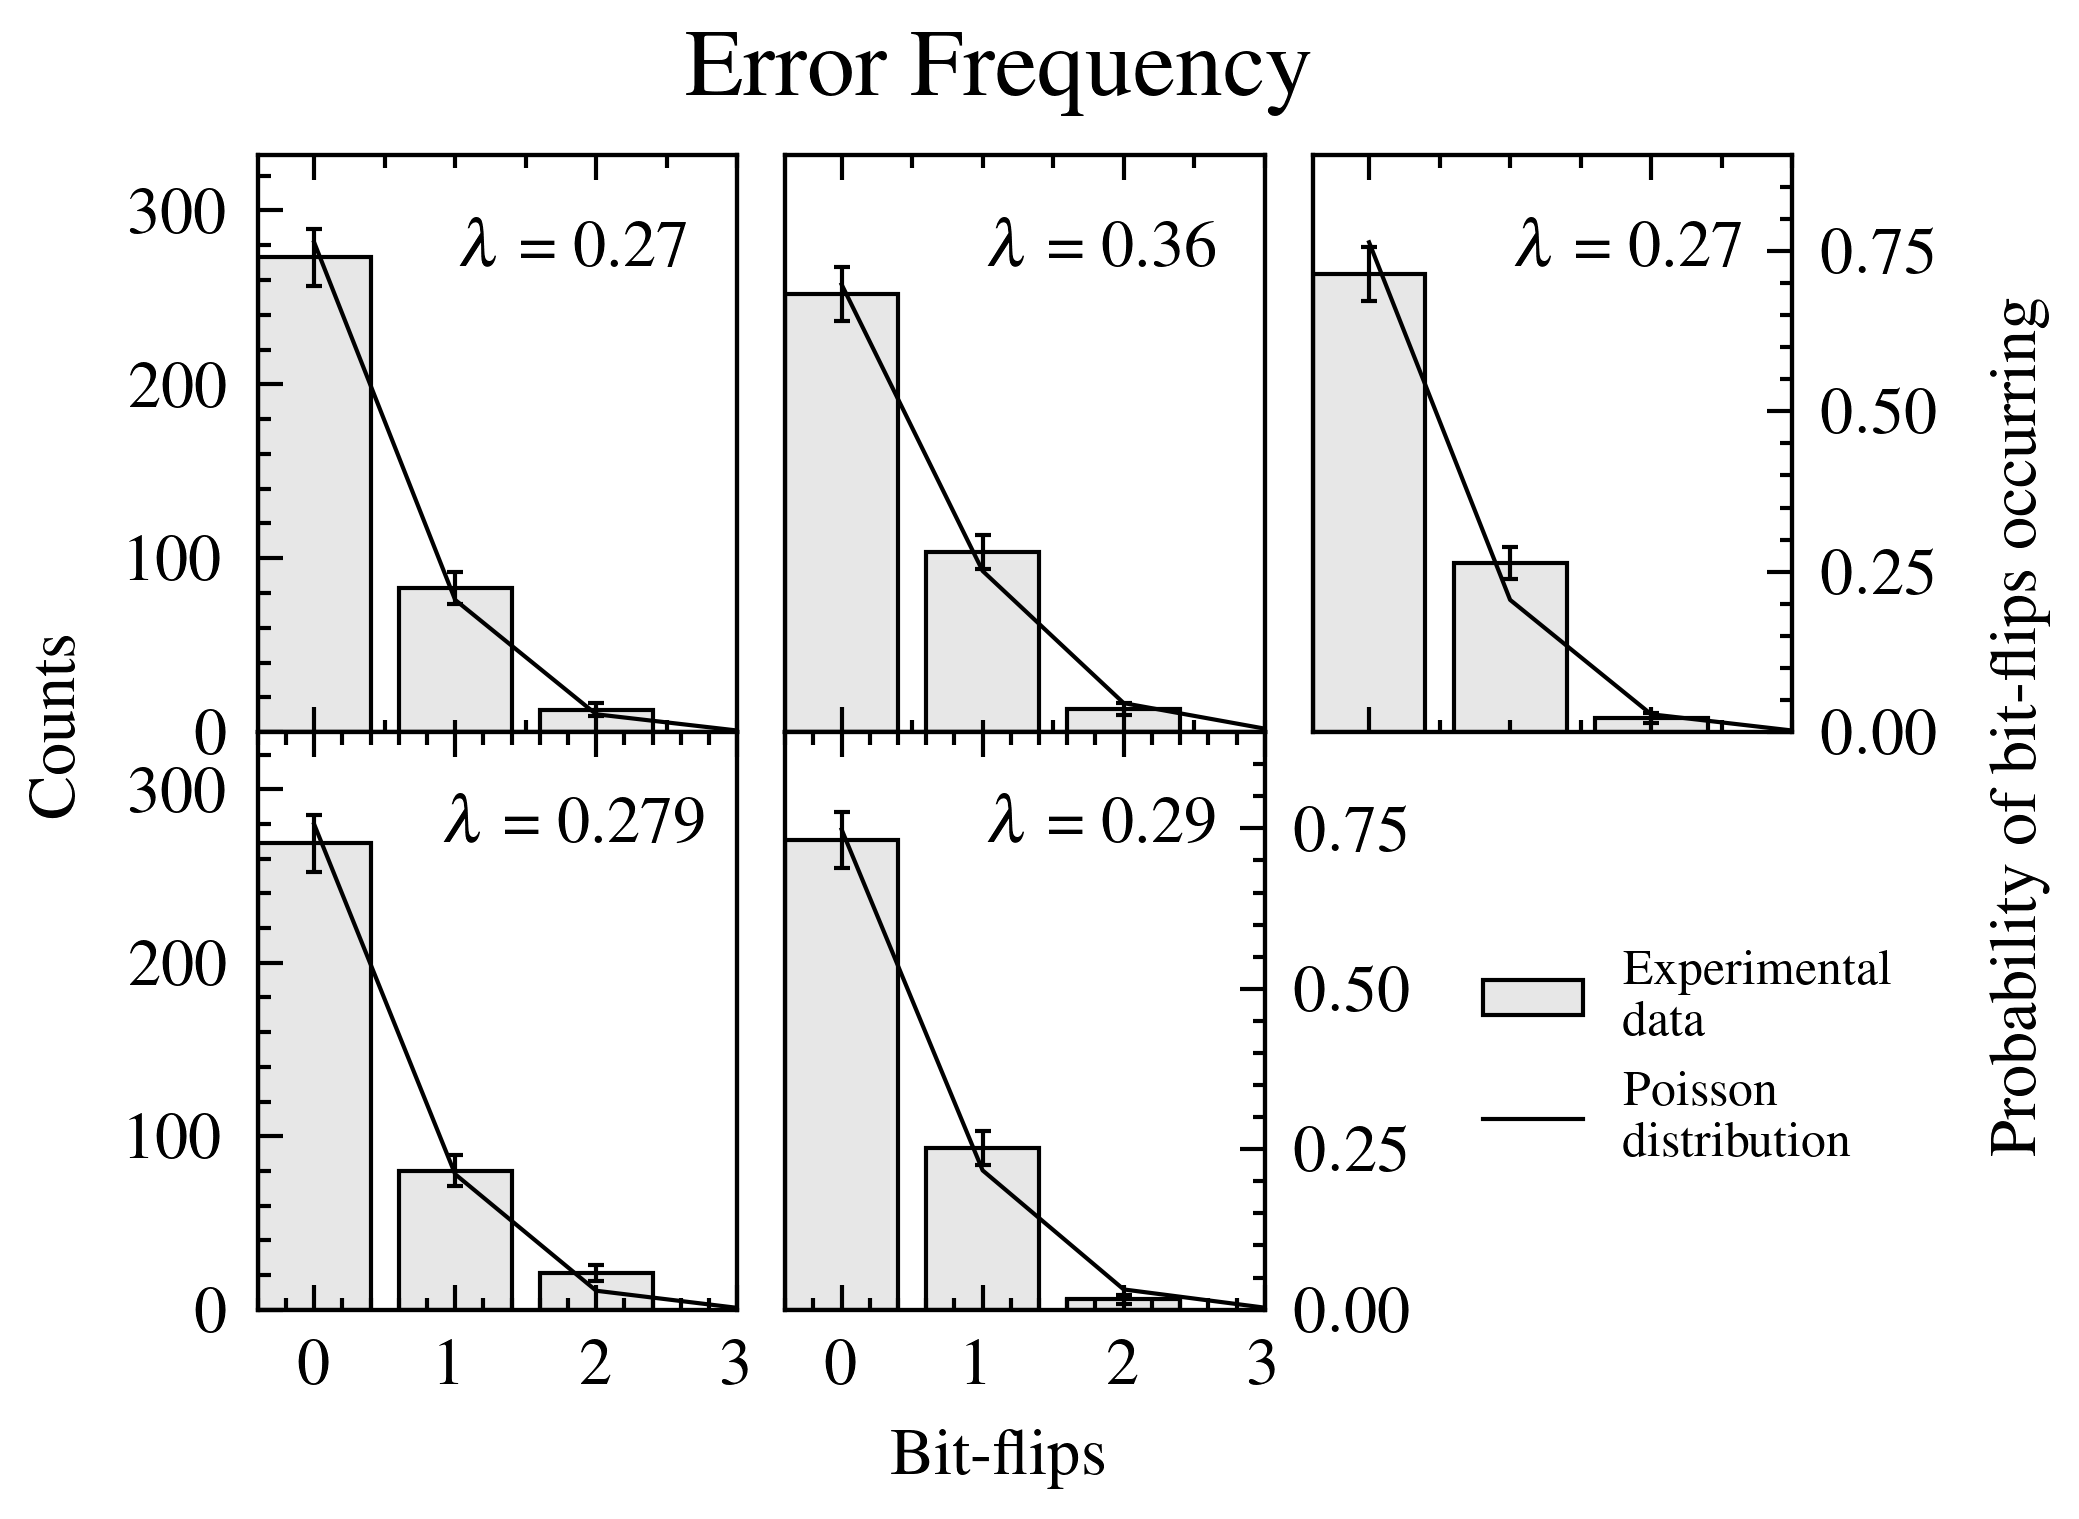

In [10]:
class PoissonData:
    def __init__(self, variant, delay, gold, lmbda):
        self.delay    = delay
        self.variant  = variant
        self.goldbyte = gold
        self.x           = [0,1,2,3]
        self.lmbda       = lmbda
        self.hamDistList = []
        self.hamDistDict = {}

    def hamDistFinder(self, error, goldbyte):
        return bin(int(error[0], 16) ^ goldbyte).count('1')

    def makeData(self):
        num_runs    = 0
        for run in self.variant.runs.values():
            if run.num not in self.variant.ignores:
                if run.errors:
                    if run.delay == self.delay:
                        for error in run.aErrNVRAM:
                            self.hamDistList.append(self.hamDistFinder(error, self.goldbyte))
                        for error in run.bErrNVRAM:
                            self.hamDistList.append(self.hamDistFinder(error, self.goldbyte))
                        for error in run.cErrNVRAM:
                            self.hamDistList.append(self.hamDistFinder(error, self.goldbyte))           
                        for error in run.dErrNVRAM:
                            self.hamDistList.append(self.hamDistFinder(error, self.goldbyte))
                    else:
                        self.hamDistList.append(0)
                    num_runs += 1
        self.hamDistDict = Counter(self.hamDistList)
        counts = list(self.hamDistDict.values())
        self.tot_err = sum(counts)
        self.poisson_data = poisson.pmf(self.x, self.lmbda)
        self.errors = [(math.sqrt(counts[0])), (math.sqrt(counts[1])),
                    (math.sqrt(counts[2]))]

poisson_sub1 = PoissonData(sram3_1_half, 0.1, 170, 0.27)
poisson_sub1.makeData()
poisson_1    = PoissonData(sram3_1_half, 1, 170, 0.279)
poisson_1.makeData()
poisson_10   = PoissonData(sram3_1_half, 10, 170, 0.36)
poisson_10.makeData()
poisson_100  = PoissonData(sram3_1_half, 100, 170, 0.29)
poisson_100.makeData()
poisson_1000 = PoissonData(sram3_1_half, 1000, 170, 0.27)
poisson_1000.makeData()

fig2 = plt.figure(1)
gs0 = gridspec.GridSpec(2, 3, figure=fig2, wspace=0.1)
rc('xtick', labelsize=8)
rc('ytick', labelsize=8)

f2_ax1 = fig2.add_subplot(gs0[0, 0])
f2_ax1.set(ylim=(0,(0.9*poisson_sub1.tot_err)))
f2_ax1.bar(poisson_sub1.hamDistDict.keys(), poisson_sub1.hamDistDict.values(),
        label='Experimental data',
        color=(0.1, 0.1, 0.1, 0.1),
        edgecolor='black',
        yerr=poisson_sub1.errors,
        align='center',
        ecolor='black',
        linewidth=0.5,
        error_kw=dict(lw=0.5, capsize=1, capthick=0.5))
f2_ax1.margins(0,0)
f2_ax1.xaxis.set_ticklabels([])
f2_ax1_2 = f2_ax1.twinx()
f2_ax1_2.set(ylim=(0,0.9))
f2_ax1_2.plot(poisson_sub1.x, poisson_sub1.poisson_data, 'k-',
                label=f'$\lambda$ = {poisson_sub1.lmbda}',
                linewidth=0.5)
f2_ax1_2.axes.get_yaxis().set_visible(False)
f2_ax1_2.text(1.85, 0.75, f'$\lambda$ = {poisson_sub1.lmbda}', ha='center', va='center')
     
f2_ax2 = fig2.add_subplot(gs0[1, 0])
f2_ax2.set(ylim=(0,(0.9*poisson_1.tot_err)))
f2_ax2.bar(poisson_1.hamDistDict.keys(), poisson_1.hamDistDict.values(),
        label='Experimental data',
        color=(0.1, 0.1, 0.1, 0.1),
        edgecolor='black',
        yerr=poisson_1.errors,
        align='center',
        ecolor='black',
        linewidth=0.5,
        error_kw=dict(lw=0.5, capsize=1, capthick=0.5))
f2_ax2.margins(0,0)
f2_ax2.xaxis.set_major_locator(ticker.MultipleLocator(1))
f2_ax2_2 = f2_ax2.twinx()
f2_ax2_2.set(ylim=(0,0.9))
f2_ax2_2.plot(poisson_1.x, poisson_1.poisson_data, 'k-',
                label=f'$\lambda$ = {poisson_1.lmbda}',
                linewidth=0.5)
f2_ax2_2.axes.get_yaxis().set_visible(False)
f2_ax2_2.text(1.85, 0.75, f'$\lambda$ = {poisson_1.lmbda}', ha='center', va='center')

f2_ax3 = fig2.add_subplot(gs0[0, 1])
f2_ax3.set(ylim=(0,(0.9*poisson_10.tot_err)))
f2_ax3.bar(poisson_10.hamDistDict.keys(), poisson_10.hamDistDict.values(), 
        label='Experimental data',
        color=(0.1, 0.1, 0.1, 0.1),
        edgecolor='black',
        yerr=poisson_10.errors,
        align='center',
        ecolor='black',
        linewidth=0.5,
        error_kw=dict(lw=0.5, capsize=1, capthick=0.5))
f2_ax3.margins(0,0)
f2_ax3.xaxis.set_ticklabels([])
f2_ax3_2 = f2_ax3.twinx()
f2_ax3_2.set(ylim=(0,0.9))
f2_ax3_2.plot(poisson_10.x, poisson_10.poisson_data, 'k-',
                label=f'$\lambda$ = {poisson_10.lmbda}',
                linewidth=0.5)
f2_ax3_2.axes.get_yaxis().set_visible(False)
f2_ax3.axes.get_yaxis().set_visible(False)
f2_ax3_2.text(1.85, 0.75, f'$\lambda$ = {poisson_10.lmbda}', ha='center', va='center')

f2_ax4 = fig2.add_subplot(gs0[1, 1])
f2_ax4.set(ylim=(0,(0.9*poisson_100.tot_err)))
f2_ax4.bar(poisson_100.hamDistDict.keys(), poisson_100.hamDistDict.values(),
        label='Experimental data',
        color=(0.1, 0.1, 0.1, 0.1),
        edgecolor='black',
        yerr=poisson_100.errors,
        align='center',
        ecolor='black',
        linewidth=0.5,
        error_kw=dict(lw=0.5, capsize=1, capthick=0.5))
f2_ax4.margins(0,0)
f2_ax4.xaxis.set_major_locator(ticker.MultipleLocator(1))
f2_ax4_2 = f2_ax4.twinx()
f2_ax4_2.set(ylim=(0,0.9))
f2_ax4_2.plot(poisson_100.x, poisson_100.poisson_data, 'k-',
                label=f'$\lambda$ = {poisson_100.lmbda}',
                linewidth=0.5)
f2_ax4.axes.get_yaxis().set_visible(False)
f2_ax4_2.text(1.85, 0.75, f'$\lambda$ = {poisson_100.lmbda}', ha='center', va='center')

f2_ax5 = fig2.add_subplot(gs0[0, 2])
f2_ax5.set(ylim=(0,(0.9*poisson_1000.tot_err)))
f2_ax5.bar(poisson_1000.hamDistDict.keys(), poisson_1000.hamDistDict.values(),
        label='Experimental data',
        color=(0.1, 0.1, 0.1, 0.1),
        edgecolor='black',
        yerr=poisson_1000.errors,
        align='center',
        ecolor='black',
        linewidth=0.5,
        error_kw=dict(lw=0.5, capsize=1, capthick=0.5))
f2_ax5.margins(0,0)
f2_ax5.xaxis.set_ticklabels([])
f2_ax5_2 = f2_ax5.twinx()
f2_ax5_2.set(ylim=(0,0.9))
f2_ax5_2.plot(poisson_1000.x, poisson_1000.poisson_data, 'k-',
                label=f'$\lambda$ = {poisson_1000.lmbda}',
                linewidth=0.5)
f2_ax5.axes.get_yaxis().set_visible(False)
f2_ax5_2.text(1.85, 0.75, f'$\lambda$ = {poisson_1000.lmbda}', ha='center', va='center')

h1, l1 = f2_ax1.get_legend_handles_labels()
h2, l2 = f2_ax1_2.get_legend_handles_labels()
l1 = ['Experimental \ndata']
l2 = ['Poisson \ndistribution']
plt.legend(h1+h2, l1+l2, bbox_to_anchor=(0, -0.8, 1.3, 0.5), prop={'size': 6})

fig2.text(0.5, 0.92, 'Error Frequency', ha='center', fontsize='x-large')
fig2.text(0.5, 0, 'Bit-flips', ha='center')
fig2.text(0.01, 0.5, 'Counts', va='center', rotation='vertical')
fig2.text(1, 0.5, 'Probability of bit-flips occurring', va='center', rotation='vertical')

plt.subplots_adjust(hspace=.0)
#plt.savefig('../../graphs/poisson/fish.svg', format='svg', dpi=1200)
plt.show()

In [37]:
class CrossSectionData:
    def __init__(self, variant):
        self.may20_june16_fluence = 1683696000000
        self.seconds              = 2332800
        self.chipir_flux          = self.may20_june16_fluence / self.seconds
        self.variant = variant
        self.cs      = 0
        self.cs_err  = 0
        self.fluence = 0

    def makeData(self):
        err_counter  = 0
        neutron_time = 0
        for run in self.variant.runs.values():
            if run.num not in self.variant.ignores:
                if run.errors:
                    err_counter += run.errors
                    run_first_tstamp = run.df.iloc[0]['Timestamp']
                    run_last_err = run.df.loc[run.df['Status'] == 'SDC'].iloc[-1]
                    run_last_err_tstamp = run_last_err['Timestamp']
                    run_first_t = dtp(run_first_tstamp, sram3_1_half.expLogTstampFormat)
                    run_last_t  = dtp(run_last_err_tstamp, sram3_1_half.expLogTstampFormat)
                    run_neutron_time = (run_last_t - run_first_t).total_seconds()
                    neutron_time += run_neutron_time
        self.fluence = neutron_time * self.chipir_flux
        self.cs = err_counter / self.fluence
        self.cs_err = ((math.sqrt(err_counter)/err_counter)+0.1)*self.cs

sram3_1_half_csdata = CrossSectionData(sram3_1_half)
sram3_1_half_csdata.makeData()
sram3_2_half_csdata = CrossSectionData(sram3_2_half)
sram3_2_half_csdata.makeData()
nvsram2_1_single_csdata = CrossSectionData(nvsram2_1_single)
nvsram2_1_single_csdata.makeData()
nvsram2_1_half_csdata = CrossSectionData(nvsram2_1_half)
nvsram2_1_half_csdata.makeData()
nvsram2_2_half_csdata = CrossSectionData(nvsram2_2_half)
nvsram2_2_half_csdata.makeData()

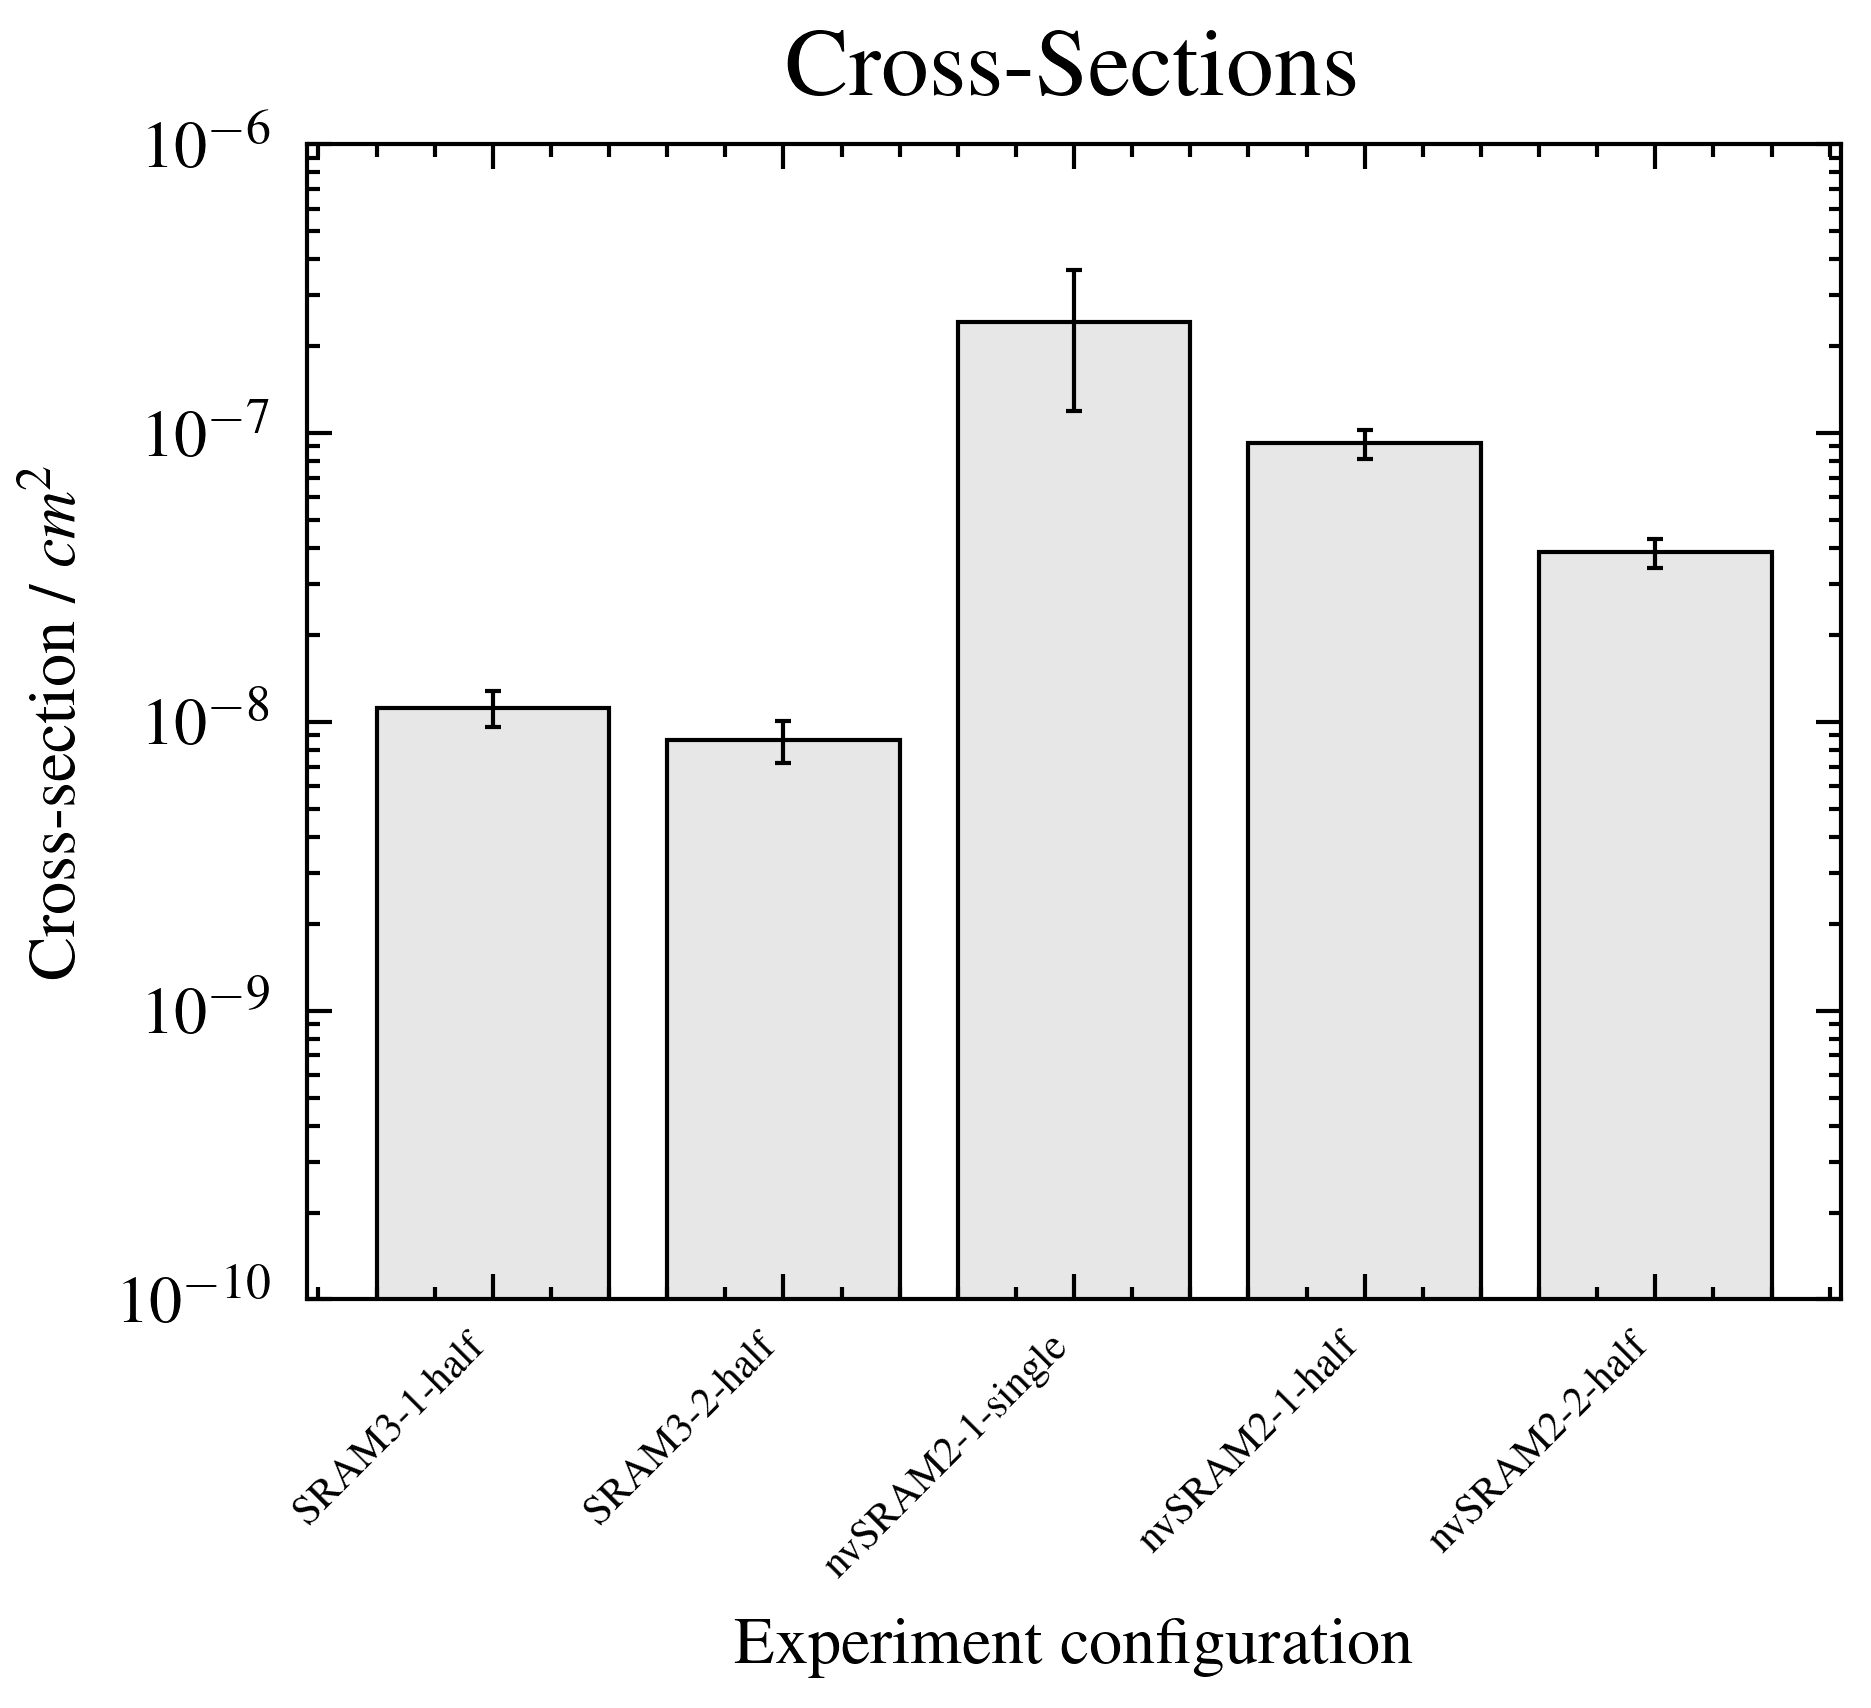

In [80]:
fig = plt.figure(3)
cs_x4 = [0,1,2,3,4]
cs_x4labs = ['SRAM3-1-half','SRAM3-2-half','nvSRAM2-1-single','nvSRAM2-1-half','nvSRAM2-2-half']
cs_y4 = [sram3_1_half_csdata.cs,sram3_2_half_csdata.cs,nvsram2_1_single_csdata.cs,nvsram2_1_half_csdata.cs,nvsram2_2_half_csdata.cs]
cs_y4err = [sram3_1_half_csdata.cs_err,sram3_2_half_csdata.cs_err,nvsram2_1_single_csdata.cs_err,nvsram2_1_half_csdata.cs_err,nvsram2_2_half_csdata.cs_err]
plt.bar(cs_x4, cs_y4, 
        color=(0.1, 0.1, 0.1, 0.1),
        edgecolor='black',
        align='center',
        ecolor='black',
        linewidth=0.5,
        yerr=cs_y4err,
        error_kw=dict(lw=0.5, capsize=1, capthick=0.5))
plt.yscale('log')
plt.ylim([1e-10,1e-6])
plt.xticks(cs_x4, cs_x4labs, rotation=45, ha='right', fontsize=5)
plt.xlabel("Experiment configuration")
plt.ylabel("Cross-section / $cm^2$")
plt.title('Cross-Sections', fontsize='x-large')
plt.savefig('../../graphs/cross_secs/cs.svg', format='svg', dpi=1200)
plt.show()

In [21]:
sram3_1_half_csdata.cs_err

4785547737.334288